In [1]:
#Imports
#Dataprep
import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets, plotting, image
from nilearn.maskers import NiftiMapsMasker
from sklearn.decomposition import FastICA
import pandas as pd
import tarfile
import gzip
#GNN required
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

## Data Clean from HCP Data notebook

In [2]:
hcp_file = 'Data/netmats_3T_HCP1200_MSMAll_ICAd100_ts2.tar.gz'

In [3]:
# Read Network Matricies
data_raw = []

with gzip.open(hcp_file, 'rb') as gz_file:
    with tarfile.open(fileobj=gz_file, mode='r') as tar:
        
        # Extract a text file
        for file in tar.getnames():
            if file.endswith('.txt'):
                # Read the content and load it into a NumPy array
                subjects = np.loadtxt(tar.extractfile(file), dtype=float)
                
                ICAd = int(np.sqrt(subjects.shape[1]))
                
                # Convert into matrix
                matrix = np.array([np.reshape(i, (ICAd, ICAd)) for i in subjects])
                data_raw.append(matrix)
net_mat2 = data_raw[1]

In [4]:
id_file = 'Data/IDs/subjectIDs.txt'
id_recon1_file = 'Data/IDs/subjectIDs_recon1.txt'
id_recon2_file = 'Data/IDs/subjectIDs_recon2.txt'
subject_IDs = np.loadtxt(id_file, dtype=int)
subject_data = pd.read_csv('Data/subjects.csv', index_col = 'Subject')
subject_data = subject_data[['Gender', 'Age']]
net_mat_data = pd.Series(dict(zip(subject_IDs, net_mat2))).to_frame().rename(columns = {0 : 'netmat'})
data = subject_data.join(net_mat_data, how = 'right')

In [5]:
data

,Gender,Age,netmat
100206,M,26-30,"[[0.0, 0.61676, 9.5727, -5.4959, 0.34639, 3.00..."
100307,F,26-30,"[[0.0, -0.29664, 17.317, -9.0467, -0.28723, 1...."
100408,M,31-35,"[[0.0, 1.6486, 6.6189, -8.8877, 1.4337, 1.006,..."
100610,M,26-30,"[[0.0, -0.90275, 7.7215, -8.3907, 3.3144, 2.93..."
101006,F,31-35,"[[0.0, -0.088768, 9.4979, -10.412, 1.0646, 4.3..."
...,...,...,...
992673,F,31-35,"[[0.0, -0.11536, 7.1338, -5.5322, 0.34004, 1.6..."
992774,M,31-35,"[[0.0, 0.25353, 8.0265, -6.2072, 4.1589, 1.582..."
993675,F,26-30,"[[0.0, -1.0378, 10.709, -3.3224, -0.090704, 2...."
994273,M,26-30,"[[0.0, 0.64613, 11.471, -5.5137, 1.9357, 4.259..."


## Pytorch data preparing

In [6]:
import torch

def create_edge_index(num_nodes):
    # Calculate the total number of edges
    num_edges = num_nodes * (num_nodes - 1) // 2

    # Initialize source and target lists
    source = []
    target = []

    # Iterate over each node
    for i in range(num_nodes):
        # Iterate over all other nodes
        for j in range(i+1, num_nodes):
            # Add a connection from i to j
            source.append(i)
            target.append(j)

    # Create the edge_index tensor
    edge_index = torch.tensor([source, target], dtype=torch.long)

    return edge_index

# Create an edge index for a fully connected graph with 100 nodes
edges = create_edge_index(100)
edges.size()

torch.Size([2, 4950])

In [7]:
import networkx as nx

C:\Users\terho\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\data\storage.py:449: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


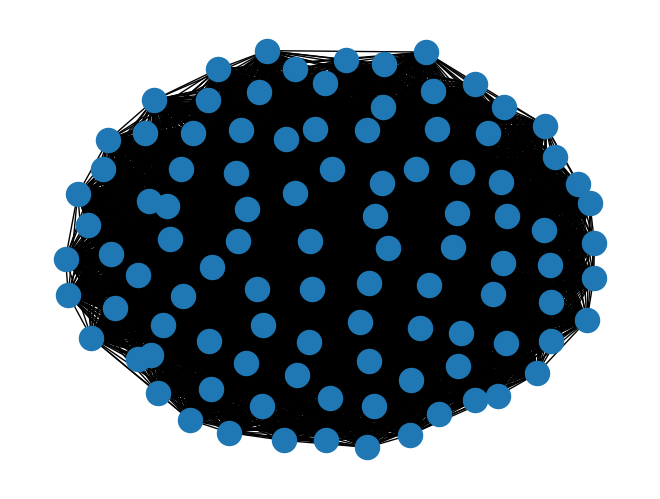

In [8]:
d = Data(x=None, edge_index=edges)
g = torch_geometric.utils.to_networkx(d, to_undirected=True)
nx.draw(g)

In [9]:
edges

tensor([[ 0,  0,  0,  ..., 97, 97, 98],
        [ 1,  2,  3,  ..., 98, 99, 99]])

In [10]:
data['Gender'] = data['Gender'].replace({"M":0, "F":1})

In [11]:
data['Gender']

100206    0
100307    1
100408    0
100610    0
101006    1
         ..
992673    1
992774    0
993675    1
994273    0
996782    1
Name: Gender, Length: 1003, dtype: int64

In [12]:
labels = torch.tensor(data['Gender'].values)
labels

tensor([0, 1, 0,  ..., 1, 0, 1])

In [13]:
edges = create_edge_index(100)

In [14]:
netmats = data['netmat']

# Custom dataset class
class CorrelationDataset(torch.utils.data.Dataset):
    def __init__(self, netmats):
        self.netmats = netmats
        self.labels = labels

    def __len__(self):
        return len(self.netmats)

    def __getitem__(self, idx):
        nmap = self.netmats.iloc[idx]
        nmap = torch.tensor(nmap)
        nmap = nmap.float()
        
        edge_index = edges
        graph_data = Data(x=nmap, edge_index=edge_index)
        
        label = self.labels[idx]

        return graph_data, label

# Create the custom dataset
custom_dataset = CorrelationDataset(netmats)
loader = DataLoader(custom_dataset, batch_size=1, shuffle=True)

In [15]:
test = iter(loader)
print(next(test))

[DataBatch(x=[100, 100], edge_index=[2, 4950], batch=[100], ptr=[2]), tensor([1])]


In [16]:
class GCN(nn.Module):
    def __init__(self,):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(100, 25)
        self.conv2 = GraphConv(25, 16)
        self.classifier = Linear(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.classifier(x).mean(dim=0)
        return torch.sigmoid(x)

In [17]:
model = GCN()

In [59]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

In [60]:
test = iter(loader)
print(next(test))

[DataBatch(x=[100, 100], edge_index=[2, 4950], batch=[100], ptr=[2]), tensor([1])]


In [61]:
model(next(test)[0])

tensor([1.], grad_fn=<SigmoidBackward0>)

In [66]:
criterion(torch.tensor([1]).double(),torch.tensor([1]).double())

tensor(0., dtype=torch.float64)

In [67]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for i_data, label in loader:
        optimizer.zero_grad()
        out = model(i_data)
        loss = criterion(out.double(), label.double())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.8f}')

Epoch 1/5, Loss: 46.75972084
Epoch 2/5, Loss: 46.75972084
Epoch 3/5, Loss: 46.75972084
Epoch 4/5, Loss: 46.75972084
Epoch 5/5, Loss: 46.75972084
